In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen_utils.data_gen_my import get_simu_data
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from CQR import get_CQR_CIs
from ddpm.train_ddpm_now import TrainDDPM
from weighted_conformal_inference import WeightedConformalInference

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
from copy import deepcopy
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [5]:
setting = "setting5"

'setting5'

In [21]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 3000
params.simu_setting.d = 10
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.25 # for conformal inference
params.simu_setting.val_ratio = 0.15 # for tuning network
params.simu_setting.update(simu_settings[setting])
params.simu_setting.n = 3000
#params.simu_setting.d = 1000
pprint(params.simu_setting)


params.nrep = 50 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = 100
params.df_dtype = torch.float32
params.device="cpu"
params.n_jobs = 30
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K

params.ddpm_training = edict()
# Batch size during training
params.ddpm_training.batch_size = 256 
# Number of training epochs
params.ddpm_training.n_epoch = 1000
params.ddpm_training.n_infeat = 128
# Learning rate for optimizers
params.ddpm_training.lr = 0.001
params.ddpm_training.lr_gamma = 0.5
params.ddpm_training.lr_step = 1000
params.ddpm_training.test_intv = 5
params.ddpm_training.n_T = 100 # 100
params.ddpm_training.n_upblk = 1
params.ddpm_training.n_downblk = 1
params.ddpm_training.weight_decay = 1e-2
params.ddpm_training.early_stop = False
params.ddpm_training.early_stop_dict = {"early_stop_len":50, "early_stop_eps": 5e-4}
#params.ddpm_training.betas = [0.001, 0.5]

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_ddpm_{setting}_test11"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25,
 'd': 10,
 'err_type': 't',
 'is_homo': True,
 'n': 3000,
 'ntest': 1000,
 'rho': 0,
 'val_ratio': 0.15}


In [22]:
torch.set_default_dtype(params.df_dtype)

In [23]:
data_train = get_simu_data(n=params.simu_setting.n, 
                             d=params.simu_setting.d, 
                             is_homo=params.simu_setting.is_homo, 
                             rho=params.simu_setting.rho, 
                             err_type="norm");

In [24]:
keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
def _get_name_postfix(keys):
    lst = []
    for key in keys:
        if params.ddpm_training[key] >= 1:
            lst.append(f"{key}-{str(params.ddpm_training[key])}")
        else:
            lst.append(f"{key}--{str(params.ddpm_training[key]).split('.')[-1]}")
    return "_".join(lst)

# Some fns

In [87]:
def _run_fn_PCP(rep_ix, params, lr, n_infeat, n_T, weight_decay, n_blk):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    params = edict(deepcopy(params))
    params.ddpm_training.n_upblk = n_blk
    params.ddpm_training.n_downblk = n_blk
    params.ddpm_training.weight_decay = weight_decay
    params.ddpm_training.n_T = n_T
    params.ddpm_training.lr = lr
    params.ddpm_training.n_infeat = n_infeat
    keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
    post_fix = _get_name_postfix(keys)
    
    torch.set_default_dtype(params.df_dtype)
    torch.set_default_device(params.device)
    
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               err_type=params.simu_setting.err_type);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho,
                               err_type=params.simu_setting.err_type);
    # let us rm all obs with T = 0
    data_test1 = edict()
    data_test1.X = data_test.X[data_test.T==1].copy()
    data_test1.Y = data_test.Y[data_test.T==1].copy()
    data_test1.Y1 = data_test.Y1[data_test.T==1].copy()
    data_test1.T = data_test.T[data_test.T==1].copy()
    data_test1.tau = data_test.tau[data_test.T==1].copy()
    data_test1.ps = data_test.ps[data_test.T==1].copy()
    data_test = data_test1
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    cal_X = torch.tensor(data_train.X[cal_idxs], dtype=params.df_dtype)
    cal_Y = torch.tensor(data_train.Y1[cal_idxs], dtype=params.df_dtype)
    val_X = torch.tensor(data_train.X[val_idxs], dtype=params.df_dtype)
    val_Y = torch.tensor(data_train.Y1[val_idxs], dtype=params.df_dtype)
    test_X = torch.tensor(data_test.X, dtype=params.df_dtype)
    test_Y = torch.tensor(data_test.Y1, dtype=params.df_dtype)
    
    # train q(Y(1)|X)
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c = val_X
    data_val.x = val_Y
    
    input_params = edict(deepcopy(params.ddpm_training))
    input_params.pop("n_epoch")
    input_params.pop("early_stop")
    input_params.pop("early_stop_dict")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}_{post_fix}", 
                       device=params.device,
                       **input_params);
    
    
    myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                     data_val=data_val, save_snapshot=params.save_snapshot, 
                     early_stop=params.ddpm_training.early_stop, 
                     early_stop_dict=params.ddpm_training.early_stop_dict
                     )
    return myddpm

In [88]:
res = _run_fn_PCP(rep_ix=4, params=params, lr=1e-2, n_infeat=128, n_T=100, weight_decay=1e-2, n_blk=1);

2024-01-06 17:31:26,058 - ddpm.train_ddpm_now - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting5_test11.
2024-01-06 17:31:26,068 - ddpm.train_ddpm_now - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 100, 'n_infeat': 128, 'n_upblk': 1, 'n_downblk': 1, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
2024-01-06 17:31:26,069 - ddpm.train_ddpm_now - WARNING - We do not do early stop, so any args in early_stop_dict are ignored.


The num of params is 0.30m. 
Adjusting learning rate of group 0 to 1.0000e-02.


loss: 0.4347: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.13it/s, val loss=1.62]

Adjusting learning rate of group 0 to 5.0000e-03.


In [89]:
myddpm = res

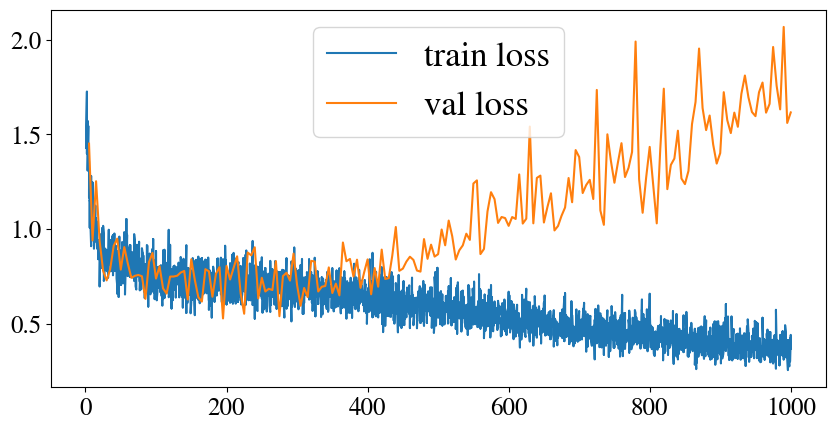

In [90]:
eps = np.array(myddpm.losses)[:, 0]
loss = np.array(myddpm.losses)[:, 1]
eps_val = np.array(myddpm.losses_val)[:, 0]
loss_val = np.array(myddpm.losses_val)[:, 1];
plt.plot(eps, loss, label="train loss")
plt.plot(eps_val, loss_val, label="val loss")
plt.legend()

# evaluate

In [170]:
ddpm = myddpm.ddpm;
data_cal = get_simu_data(n=200, 
                          d=params.simu_setting.d, 
                          is_homo=params.simu_setting.is_homo, 
                          rho=params.simu_setting.rho);
cal_X = torch.tensor(data_cal.X[data_cal.T==1], dtype=params.df_dtype)
cal_Y = torch.tensor(data_cal.Y1[data_cal.T==1], dtype=params.df_dtype);

data_test = get_simu_data(n=1000, 
                          d=params.simu_setting.d, 
                          is_homo=params.simu_setting.is_homo, 
                          rho=params.simu_setting.rho);
test_X = torch.tensor(data_test.X[data_test.T==1], dtype=params.df_dtype)
test_Y = torch.tensor(data_test.Y1[data_test.T==1], dtype=params.df_dtype);

In [171]:
wcf0 = WeightedConformalInference(cal_X, 
                                 cal_Y,
                                 ddpm, ws_fn=None, verbose=2, 
                                 seed=0,
                                 gen_type="ddpm",
                                 n_jobs=params.n_jobs,
                                 inf_bs=params.inf_bs,
                                 device=params.device,
                                 wcf_params={
                                    "K": params.K, # num of sps for each X
                                    "nwhigh" : params.wconformal.nwthigh,
                                    "nwlow" : params.wconformal.nwtlow,
                                    "useinf": params.wconformal.useinf,
                                 })

2024-01-06 17:55:48,537 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-06 17:55:48,538 - weighted_conformal_inference - INFO - wcf params is {'gen_type': 'ddpm'}


In [173]:
wcf1 = WeightedConformalInference(cal_X, 
                                 cal_Y,
                                 ddpm, ws_fn=None, verbose=2, 
                                 seed=0,
                                 gen_type="ddim",
                                 n_jobs=params.n_jobs,
                                 inf_bs=params.inf_bs,
                                 device=params.device,
                                 gen_params = {"ddim_eta": 0},
                                 wcf_params={
                                    "K": params.K, # num of sps for each X
                                    "nwhigh" : params.wconformal.nwthigh,
                                    "nwlow" : params.wconformal.nwtlow,
                                    "useinf": params.wconformal.useinf,
                                 })

2024-01-06 17:55:52,255 - weighted_conformal_inference - INFO - wcf params is {'K': 40, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
2024-01-06 17:55:52,256 - weighted_conformal_inference - INFO - wcf params is {'ddim_timesteps': 50, 'ddim_eta': 0, 'gen_type': 'ddim'}


In [176]:
_get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
def _get_inset(vs, intvs):
    in_set = []
    for v, intv in zip(vs, intvs):
        in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
    in_set = np.array(in_set)
    return in_set
CI0s = wcf0(test_X);
CI1s = wcf1(test_X);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12949.02it/s]


In [178]:
_get_intvs_len(CI0s).mean(), _get_intvs_len(CI1s).mean()

(5.607655, 7.948876)

In [179]:
_get_inset(test_Y, CI0s).mean(), _get_inset(test_Y, CI1s).mean()

(0.9807692307692307, 0.9855769230769231)

## ON test set

In [120]:
data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);

In [127]:
tX = torch.tensor(data_test.X, dtype=params.df_dtype);

In [140]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(tX, device="cpu", is_store=False);
ddpm.eval()
with torch.no_grad():
    x1_i, x1_is = ddpm.sample_ddim(tX, ddim_timesteps=50, ddim_eta=1, device="cpu", is_store=False);

(-10.0, 10.0)

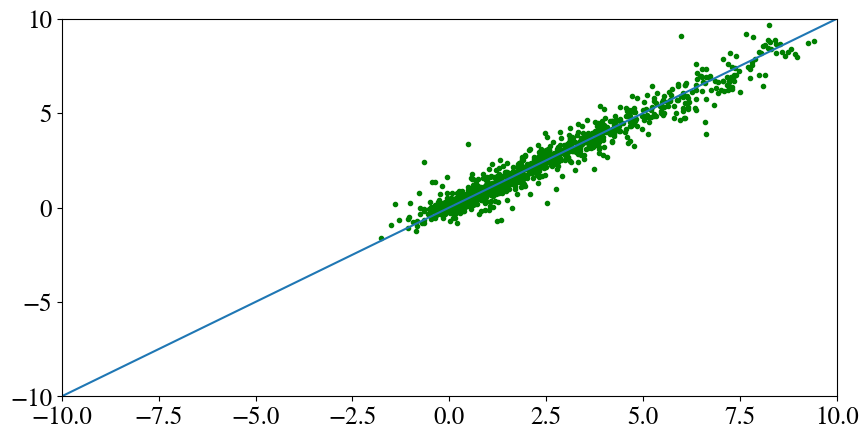

In [141]:
x_i = x_i.reshape(-1).numpy();
x1_i = x1_i.reshape(-1).numpy();
x0 = data_test.Y1;
#plt.plot(x0, x_i, "Hb")
#plt.plot(x0, x1_i, ".r")
plt.plot(x_i, x1_i, ".g")
xx = np.linspace(-10, 10, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

(-10.0, 10.0)

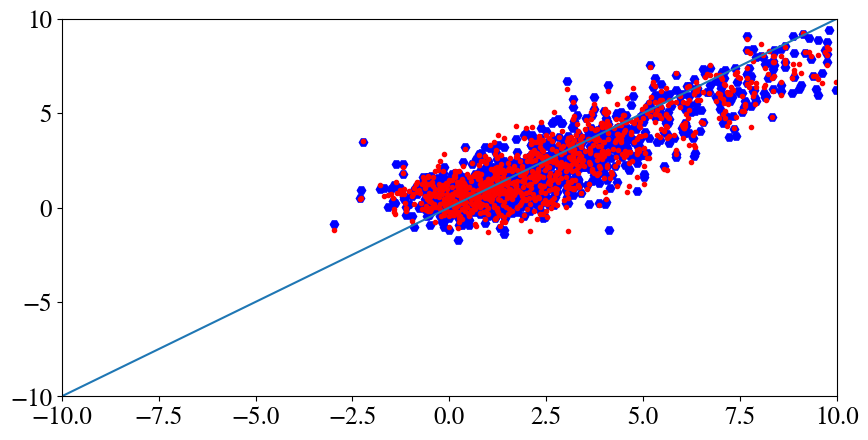

## Given X

In [103]:
datatest_con = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               is_condition=True);
tX_con = torch.tensor(datatest_con.X, dtype=params.df_dtype);

In [105]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(tX_con, device="cpu", is_store=True);

In [117]:
ddpm.eval()
with torch.no_grad():
    x1_i, x1_is = ddpm.sample_ddim(tX_con, ddim_timesteps=25, ddim_eta=0, device="cpu", is_store=True);

(-5.0, 10.0)

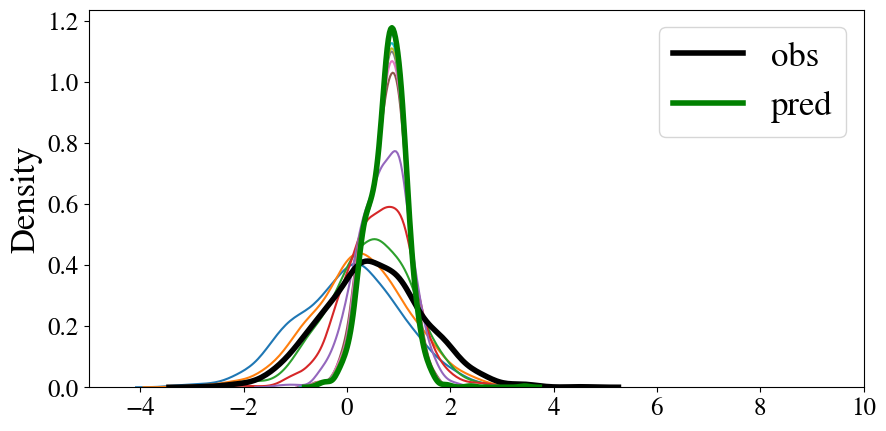

In [118]:
predx0 = x_i.reshape(-1).numpy();
x0 = datatest_con.Y1;
x_is = x_is.squeeze();
for idx in range(x_is.shape[0]):
    sns.kdeplot(x_is[idx])
sns.kdeplot(x0, color="black", lw=4, label="obs")
sns.kdeplot(predx0, color="green", lw=4, label="pred")
plt.legend()
plt.xlim([-5, 10])

(-5.0, 10.0)

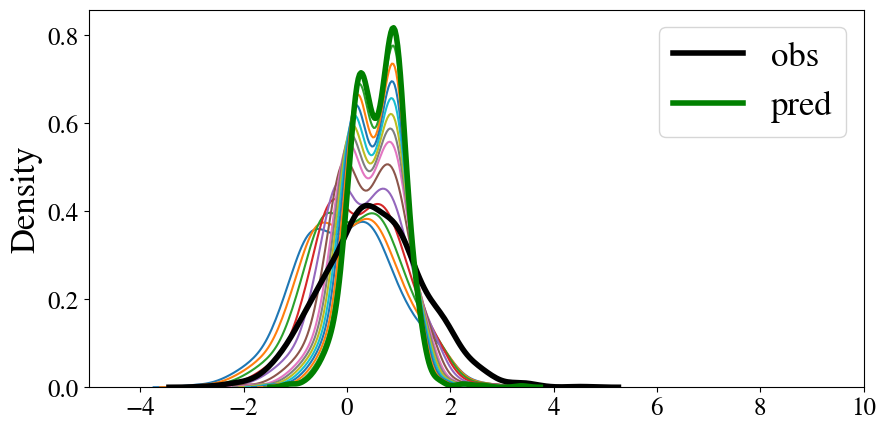

In [119]:
predx1 = x1_i.reshape(-1).numpy();
x0 = datatest_con.Y1;
x1_is = x1_is.squeeze();
for idx in range(x1_is.shape[0]):
    sns.kdeplot(x1_is[idx])
sns.kdeplot(x0, color="black", lw=4, label="obs")
sns.kdeplot(predx1, color="green", lw=4, label="pred")
plt.legend()
plt.xlim([-5, 10])